In [1]:
import math
import pandas as pd
import numpy as np
import networkx as nx
import csv
import random
import matplotlib.pyplot as plt
import statistics 
from scipy import stats
from scipy.spatial import distance
import io
import time#for recording time 
import sys #for getting size of object
!pip install texttable
from texttable import Texttable

plt.rcParams["figure.figsize"] = (10,10)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
random.seed(15)

### *Importing files from github for google colab


In [3]:
url = 'https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/contact_rules.csv'
rules_df  = pd.read_csv(url,header=None,engine='python')
url2='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/frequency_contact.csv'
frequency_df= pd.read_csv(url2,header=None,engine='python')
url3='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/varicella_prevalance.csv'
V_prevalence_df =pd.read_csv(url3,header=None,engine='python')
url4='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/population.csv'
population_df=pd.read_csv(url4,header=None,engine='python')
url5='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/skewness.csv'
skewness_df=pd.read_csv(url5,header=0,engine='python')
url6='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/Age_exact.csv'
age_exact_df=pd.read_csv(url6,header=0,engine='python')
url7='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/mortality.csv'
death_rate_df=pd.read_csv(url7,header=0,engine='python')

### *importing files from pc


# THE GRAPH CONTROL PANEL

In [4]:
N =10000# Number of nodes
setting='home'#the setting we are evaluating(home,work,school,other)
clustering_factor=1000 #multiplies chance of connecting with N_of_N
clustering=True
sampling_ratio=1000 #In how many iterations we calculate metrics
skewed = True
symetricality=True # if we are using original contact data or transform it to be symetrical 
birth_rate=14.4/1000 #belongs to year 2019

## 1-Defining Nodes

In [5]:
#defining a dictionary of nodes

group_popularity = dict() #based on consensus year 95
v_prevalence=dict() #based on meta analysis(data is not exact!! update needed!!)contan(age_group,prevalance,lower CL)
nodes_dic=dict() #dictionary of nodes
frequency=dict()
death_r=dict()
nodes_list=list()


for i, row in age_exact_df.iterrows():
    group_popularity[row[0]]=float(row[1])
    
for i, row in death_rate_df.iterrows():
    death_r[row[0]]=float(row[3])
    
for i, row in V_prevalence_df.iterrows():
    v_prevalence[row[0]]=[float(row[1]),float(row[2])]
    


                    
for i in range(N):#deciding nodes ages
    while True:
        r=random.random()
        t=random.choice(list(group_popularity.keys()))
        if r<=group_popularity[t]:
            nodes_list.append([t])
            break

            
death_age_group=[['0_1', 0, 1], [' 1_4 ', 1, 4], [' 5_9 ', 5, 9], [' 10_14 ', 10, 14], [' 15_19  ', 15, 19], [' 20_24 ', 20, 24], [' 25_29 ', 25, 29], [' 30_34 ', 30, 34], [' 35_39 ', 35, 39], [' 40_44 ', 40, 44], [' 45_49 ', 45, 49], [' 50_54 ', 50, 54], [' 55_59 ', 55, 59], [' 60_64 ', 60, 64], [' 65_69 ', 65, 69], [' 70_74 ', 70, 74], [' 75_79 ', 75, 79], [' 80_84 ', 80, 84], ['85_200', 85, 200]]           
#changing population by birth and death to update the data
dead_nodes=[]
for i in range(1):
    #counting number of birth
    count_birth=int(abs(birth_rate*(len(nodes_list))))
    #adding to ages
    for j in range(len(nodes_list)):
        nodes_list[j][0]+=1
    #birth of nodes   
    for j in range(count_birth):
        nodes_list.append([0])  
    #death of nodes
    for j in range(len(nodes_list)):
        death_age=False
        #checking the age of node
        for k in death_age_group:
            if death_age==False:
                if nodes_list[j][0]>=k[1] and nodes_list[j][0]<=k[2]:
                    age_bucket=k[0]
                    death_age=True
                    
        r=random.random()
        #checking if node dies
        if r <= death_r[age_bucket]:
            nodes_list[j]='D'
    #removing dead nodes from list 
    while 'D' in nodes_list:
        nodes_list.remove('D')
        
#putting final list to dict        
for i in range(len(nodes_list)):
    nodes_dic[i]={'age_E':nodes_list[i][0]}
                    
#putting ages into buckets
age_groups=[['0_4', 0, 4],['5_9', 5, 9],['10_14', 10, 14],['15_19', 15, 19],['20_24', 20, 24],['25_29', 25, 29],['30_34', 30, 34],['35_39', 35, 39],['40_44', 40, 44],['45_49', 45, 49],['50_54', 50, 54],['55_59', 55, 59],['60_64', 60, 64],['65_69', 65, 69],['70_74', 70, 74],['75+', 75,200]] 
for i in nodes_dic.keys():
    bucket = False
    for j in age_groups :
        if bucket== False and nodes_dic[i]['age_E'] <= j[2] and nodes_dic[i]['age_E'] >=j[1]:
            nodes_dic[i]['age']=j[0]
            bucket=True


#for i in range(N):  #deciding nodes seropositivity
   # a=v_prevalence[nodes_dic[i]['age']][0]
   # b=v_prevalence[nodes_dic[i]['age']][1]
   # r=np.random.random()
   # t=np.random.normal(a,(a-b)) 
   # if r<=t:
   #     nodes_dic[i]['infection']=1
   # else:
      #  nodes_dic[i]['infection']=0        

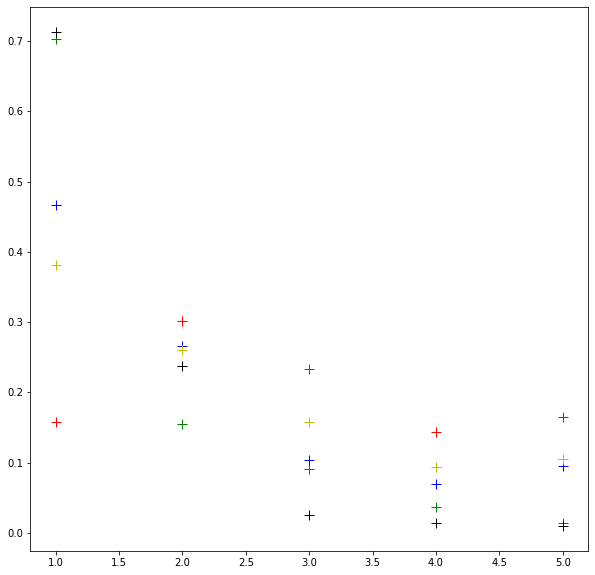

In [6]:
#importing data for frequency of contact in each setting for comparison
for i, row in frequency_df.iterrows():
    frequency[row[0]]=dict()
    for i in range(1,6):
        frequency[row[0]][i]=float(row[i])
        
colors={'home':'g+','school':'k+','work':'b+','others':'r+','all':'y+'}       
for i in frequency.keys():
    for j in frequency[i].keys():
        plt.plot(j,frequency[i][j],colors[i],linewidth=2, markersize=10,alpha=1)

### Which `group` each node belongs to?

* We  used `Age specific population for Iran` to define probability of each group

In [7]:

# the number of nodes in each group:

age_count = {}
for n in nodes_dic.keys():
    if nodes_dic[n]['age'] in age_count:
        age_count[nodes_dic[n]['age']] = age_count[nodes_dic[n]['age']] + 1
    else:
        age_count[nodes_dic[n]['age']] = 1
age_count

{'30_34': 1108,
 '0_4': 849,
 '45_49': 686,
 '5_9': 813,
 '35_39': 901,
 '40_44': 713,
 '55_59': 424,
 '65_69': 235,
 '20_24': 718,
 '15_19': 680,
 '10_14': 717,
 '50_54': 521,
 '25_29': 986,
 '60_64': 350,
 '75+': 244,
 '70_74': 141}

## 2-Defining Connection Rules between Node Groups

### `We define rules in terms of connection probability between each two groups`


In [8]:
#importing rules_data from .csv to nested dictionary
rules_data={}  # rules_data contain ->{location:{contactor:{contactee:contact number}
temp_0={}
temp_1={}
location=[]
contactor=[]
contactee=[]
contact_number=[]

for i, row in rules_df.iterrows():
    
    location.append(row[0])
    contactor.append(row[1])
    contactee.append(row[2])
    contact_number.append(float(row[3]))

for o in range (0,1280,256):
    for m in range(o,o+256,16):
        for n in range (m,m+16):
            
            temp_0[contactee[n]]=contact_number[n]
        temp_1[contactor[m]]=temp_0.copy()
    rules_data[location[o]]=temp_1.copy()     

In [9]:
#transforming rules_data to rules so it will be symetrical
#It should be symetrical for building undirected graph

rules=dict()

if symetricality == False :
    
    rules=rules_data

else:

    for i in rules_data.keys():
        rules[i]=dict()
        for j in rules_data[i].keys():
            rules[i][j]=dict() 
            for k in rules_data[i][j].keys():

                total_j_k_contact=(rules_data[i][j][k]*age_count[j])+(rules_data[i][k][j]*age_count[k])
                rules[i][j][k]=(total_j_k_contact/2)/age_count[j]

In [10]:
#claculating how many contact a person has with all age groups in the setting
#calculating how many 'connectons' is required for the contacts with specific frequency
rules_sum=dict()
for i in rules.keys():
    rules_sum[i]=dict()
    for j in rules[i].keys():
        t=0
        rules_sum[i][j]={'contact_total':0,'count1':0,'count2':0,'count3':0}
        for k in rules[i][j]:
            t+=rules[i][j][k]
    
        rules_sum[i][j]['contact_total']=t
        rules_sum[i][j]['count1']=t*frequency[i][1]
        rules_sum[i][j]['count2']=t*frequency[i][2]*(7/1.5)
        rules_sum[i][j]['count3']=t*frequency[i][3]*(30/1.5)
        #number of 'contacts' with random probability
        rules_sum[i][j]['count4']=t*(frequency[i][4]+frequency[i][5])
        rules_sum[i][j]['connection_total']=rules_sum[i][j]['count1']+rules_sum[i][j]['count2']+rules_sum[i][j]['count3']
        
        
#a dictionary of weight/upper_weight ratio for each frequency set       
frequency_grouped={1:1,2:(1.5/7),3:(1.5/30),4:0}

table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['setting','age','contact_total','connection_total','conection 1','conection 2' ,'conection 3','connection 4']],header=True)      
print(table.draw())
for i in rules_sum.keys():
    for j in rules_sum[i].keys():
        
        table.add_rows([[i,j,'%f' % rules_sum[i][j]['contact_total'],'%f' % rules_sum[i][j]['connection_total'],'%f' % rules_sum[i][j]['count1'],'%f' % rules_sum[i][j]['count2'],'%f' % rules_sum[i][j]['count3'],'%f' % rules_sum[i][j]['count4']]],header=True)
        
        print(table.draw())


setting   age   contact_t   connecti   conectio   conectio   conectio   connecti
                  otal      on_total     n 1        n 2        n 3        on 4  
  all     0_4   10.607603   50.57108   4.048073   12.91835   33.60465   2.111077
                               3                     5          4               
  all     5_9   18.271025   87.10597   6.972589   22.25117   57.88221   3.636217
                               3                     3          1               
  all     10_   21.738824   103.6384   8.295970   26.47439   68.86812   4.326363
          14                   85                    4          0               
  all     15_   19.133753   91.21897   7.301823   23.30183   60.61531   3.807914
          19                   3                     7          3               
  all     20_   12.763697   60.85013   4.870882   15.54413   40.43511   2.540174
          24                   0                     3          5               
  all     25_   12.003688   

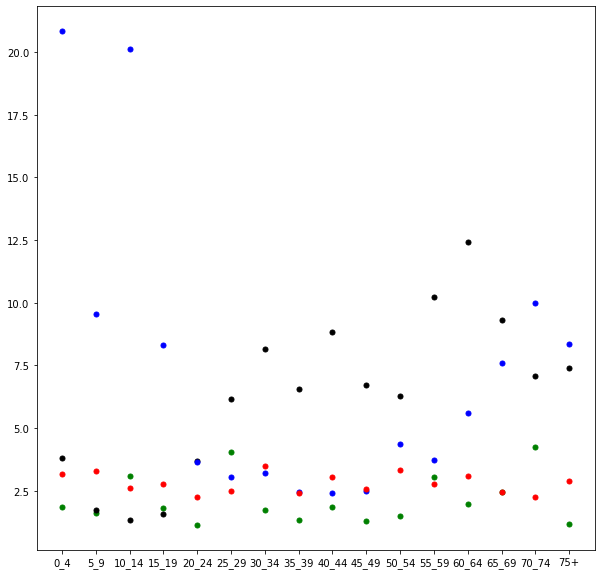

In [11]:
#importing skewness of distribution of number of contacts for each age in each setting 
skewness=dict()
for i, row in skewness_df.iterrows():
    
    if row[0] in list(skewness.keys()):
        skewness[row[0]][row[1]]=row[2]
    else:
        skewness[row[0]]=dict()
        skewness[row[0]][row[1]]=row[2]

colors={'home':'g.','school':'k.','work':'b.','others':'r.'}
for i in skewness.keys():
    for j in skewness[i].keys():
        plt.plot(i,skewness[i][j],colors[j],linewidth=2, markersize=10,alpha=1)

## 3-Defining Functions



### 3-1 function run : builds the graph based on rules of connections

In [12]:
#in this block we've defiend a function "Run" 
def Run(nodes_dic,age_count,frequency_grouped):
    
    #building the array based on nodes_dic
    #graph_array=[N * [[connecetions],number of the node,number of connections]
    graph_array=[]
    for i in nodes_dic.keys():
        Age_i=nodes_dic[i]['age']
        Num_connection = np.random.poisson(lam=(rules_sum[setting][Age_i]['contact_total']))
        graph_array.append([[],i,Num_connection])
 
    #making a dictionary that consists of lists of nodes in each age group
    nodes_age_grouped=dict() 
    for i in nodes_dic.keys():     
        if nodes_dic[i]['age'] in nodes_age_grouped:
            nodes_age_grouped[nodes_dic[i]['age']].append(i)    
        else:
            nodes_age_grouped[nodes_dic[i]['age']]=[i]
            
            
    #for storing metrics during run
    samples_T={'p-value wilcoxon': [], 'mean absoloute error': [], 'Manhattan distance': [], 'Euclidean distance': [], 'Chebyshev distance': []}
    
    #building primary graph
    print('building primary graph ...')
    
    #iterating nodes
    for contactor in nodes_dic.keys():
        #checking if they have any place for new connection
        if len(graph_array[contactor][0]) < graph_array[contactor][2]:
            Age_contactor=nodes_dic[contactor]['age']
            not_connected = True #for checking if conection has happend
            
            while not_connected :
                #deciding age of connection
                Age_C=random.choice(list(nodes_age_grouped.keys()))
                r=random.random()
                prob_connection=rules[setting][Age_contactor][Age_C]/(rules_sum[setting][Age_contactor]['contact_total'])
                
                if r <= prob_connection :
                    #deciding a random node from the chosen age group to make connection

                    contactee= random.choice(list(nodes_age_grouped[Age_C]))
                    
                    #checking if contactee has empty capacity
                    
                    
                    if len(graph_array[contactee][0]) < graph_array[contactee][2]:

                        if contactee not in graph_array[contactor][0] and contactee != contactor :

                            not_connected = False

                            graph_array[contactor][0].append(contactee)
                            graph_array[contactee][0].append(contactor)
    #for calculating sampling_ratio               
    sampling_counter=0                                       
    #building complete graph
    print('building complete graph ...')
    for contactor in nodes_dic.keys():
        
        sampling_counter+=1
        
        if sampling_counter == sampling_ratio :
            
            sampling_counter=0
            #calculating metrics for graph at the moment
            samples=sampling(N,graph_array,age_count,rules)
            #storing the metrics
            for metric in samples_T.keys():
                samples_T[metric].append(samples[metric])
            
        Age_contactor=nodes_dic[contactor]['age']
        
        #claculating remaining number of connections to build       
        counter = graph_array[contactor][2]-len(graph_array[contactor][0])
        
        dead_end=False #for checking if there is not enough empty spots to connect this node
        #completing graph 
        
        #building primary list of N_of_N
        N_of_N=list()
        for j in graph_array[contactor][0]:

            for k in graph_array[j][0]:
                
                if k!=contactor and k not in graph_array[contactor][0]:
                    
                    N_of_N.append(k)

        N_of_N=list(set(N_of_N))
                
        while counter > 0 and not dead_end :
            
            #connecting to N_of_N and making triangels
            if clustering :
                
                for i in range(clustering_factor):
                    
                    #iterating in N_of_N to make connections
                    for contactee in N_of_N :

                        if counter > 0 :

                            Age_C=nodes_dic[contactee]['age']
                            prob_connection=rules[setting][Age_contactor][Age_C]/(rules_sum[setting][Age_contactor]['contact_total']*age_count[Age_C])
                            r=random.random()
                            #checking if contactee has free capacity
                            if len(graph_array[contactee][0]) < graph_array[contactee][2]:
                                if r <= prob_connection and contactee not in graph_array[contactor][0]:

                                        counter-=1

                                        graph_array[contactor][0].append(contactee)
                                        graph_array[contactee][0].append(contactor) 
            
            #making random connections if N_of_N doesn't have enouhg nodes
            if counter > 0:
                counter_null_iteration=0#counts number of iterations that fail to form connection
                random_connection =False
                while random_connection == False and not dead_end :
                    
                    #deciding age of connection
                    Age_C=random.choice(list(nodes_age_grouped.keys()))
                    r=random.random()
                    prob_connection=rules[setting][Age_contactor][Age_C]/(rules_sum[setting][Age_contactor]['contact_total'])
                    
                    if r <= prob_connection:
                        #deciding a random node from the chosen age group to make connection

                        contactee= random.choice(list(nodes_age_grouped[Age_C]))
                        counter_null_iteration+=1
                        
                        #if we have iterated 1000 times without forming connection the node is in dead end
                        if counter_null_iteration > 1000 :
                            dead_end=True
                            print(contactor,'hit dead end')
                        
                        #checking contactee for capacity of new connections
                        if len(graph_array[contactee][0]) < graph_array[contactee][2]:

                            if contactee not in graph_array[contactor][0] and contactee != contactor :

                                random_connection = True
                                counter-=1

                                graph_array[contactor][0].append(contactee)
                                graph_array[contactee][0].append(contactor)
                                
                                #building N_of_N based on newly added node
                                N_of_N=list()
                                
                                for j in graph_array[contactee][0]:
                                    
                                    if j!=contactor and j not in graph_array[contactor][0]:

                                         N_of_N.append(j)



#putting data from graph to a list of connections
    connections_list=list()
    for i in nodes_dic.keys():
        for j in range(len(graph_array[i][0])):
            k=graph_array[i][0][j]
        
            if i<k:
                connections_list.append((i,k))
            elif k<i:
                connections_list.append((k,i))
    #removing duplicates
    connections_list=list(set(connections_list))
    
                             
    results={'graph_array':graph_array,'nodes_age_grouped':nodes_age_grouped,'connections':connections_list,'samples_T':samples_T}                           
    return(results)


### 3-2 function Run_S imports graph and checks for connections in each day 

In [13]:
#Run_S runs the model and stores conections but do not change the weights
def Run_S (nodes_dic,N_day,rules,age_count,N,results):
    
    nodes_age_grouped=results['nodes_age_grouped']
    graph_array=results['graph_array']
    connections=results['connections']

    #in this list the day that connection has happened is stored
    #contacts=[N*[D0[],D1[]]]
    contacts=[] 
    for i in nodes_dic.keys():
        contacts.append([])
        
            
    for d in range(N_day):
        #adding empty list for day to each node
        for i in nodes_dic.keys():
            contacts[i].append([])
         #checking if contacts happen and storing them   
        
        for j in connections:
            contacts[j[0]][d].append(j[1])
            contacts[j[1]][d].append(j[0])
                    
    return(contacts)


### 3-3 function sampling checks the graph and calculates metrics during the run

In [14]:
#this function claculates metric for graph during the run

def sampling(N,graph_array,age_count,rules):
    #builds list of contacts based on current situation of graph
    contacts=[]
    for node in nodes_dic.keys():
        contacts.append([])
        contacts[node].append(graph_array[node][0])
    #calculates metrics    
    Metr_W = Metric_W(contacts,age_count,rules)
    
    samples={'p-value wilcoxon':'%f' % Metr_W['wilx'][1],'mean absoloute error':Metr_W['M_Abs'],'Manhattan distance':Metr_W['man_dis'],'Euclidean distance':Metr_W['eu_dis'],'Chebyshev distance':Metr_W['cheb_dis']}
     
    return(samples)

### 3-4 function Metric_w calculates metrics for the input graph

In [15]:
#this function returns measures for comparison age stratified number of contacts 


def Metric_W(Run_S,age_count,rules) : 
    

    contacts=Run_S
    
    
    L1=[]
    L2=[]
    L3=[]
    

    rules_m=dict()
    rules_m[setting]=dict()

    for i in rules[setting].keys():
        rules_m[setting][i]=dict()
        for j in rules[setting][i].keys():
             rules_m[setting][i][j]=0
    
    for i in nodes_dic.keys():
            for j in contacts[i][0]:
                age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]
                if i!=j and age_p!=0 : 
                    t= 1/age_count[nodes_dic[i]['age']]
                    rules_m[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]+=t
                         
    for i in rules_m[setting].keys():
        for j in rules_m[setting][i].keys():
            
            L1.append(rules[setting][i][j])
            L2.append(rules_m[setting][i][j])
            
            L3.append(abs((rules_m[setting][i][j])-(rules[setting][i][j])))
    
                
                
    wilx=stats.wilcoxon(L1,L2,zero_method='wilcox', correction=False, alternative='two-sided')
    
    M_Abs=statistics.mean(L3)
    #Manhattan distance
    man_dis=distance.cityblock(L1, L2)
    #Euclidean distance
    eu_dis=distance.euclidean(L1,L2)
    #Chebyshev distance
    cheb_dis=distance.chebyshev(L1,L2)
    #Pearson corelation
    prs_cor=stats.pearsonr(L1,L2)
    
    
    Metric_W ={'wilx':wilx,'M_Abs':M_Abs,'rules_m':rules_m,'L3':L3,'man_dis':man_dis,'eu_dis':eu_dis,'cheb_dis':cheb_dis, 'prs_cor': prs_cor}
    
    return(Metric_W)

### 3-5 function clustering_coefficent calculate number of triangles and ratio of contacts involved in a triangel compared to total  contacts with possibility of forming triangles

In [16]:
#claculate clustering by counting number of triangels
def clustering_rate (results):
    
   
    graph_array=results['graph_array']
    t_triangel=0
    t_contact=0
    for node in nodes_dic.keys():
        if len(graph_array[node][0])>1:
            #building list of neighbor of neighbors
            N_of_N=[]
            for neighbor in graph_array[node][0]:
                for neighbor2 in graph_array[neighbor][0]:
                    N_of_N.append(neighbor2)
            #checking for triangels

            for neighbor in graph_array[node][0]:
                #if it's possible for the node to build triangels
                if len(graph_array[neighbor][0])>1:
                    t_contact+=1
                if neighbor in N_of_N :
                    t_triangel += 1
                    
                    
                
    t_contact=t_contact/2 
    t_triangel=t_triangel/2
    ratio_triangel=(t_triangel)/t_contact
                
    return(t_triangel,ratio_triangel)

# 4-Running the model
### the functions run in this part




In [17]:
start = time.time()

In [18]:
#this part runs the model
results=Run(nodes_dic,age_count,frequency_grouped)


building primary graph ...
building complete graph ...
9380 hit dead end
9677 hit dead end
9738 hit dead end
9854 hit dead end
9866 hit dead end
9877 hit dead end
9883 hit dead end
9897 hit dead end
9996 hit dead end
10007 hit dead end


In [19]:
end=time.time()

In [20]:
#running a 1 day simulation of model
contacts=Run_S(nodes_dic,1,rules,age_count,N,results)

In [21]:
#this part returns the measures for age stratified number of contact
Metr_W=Metric_W(contacts,age_count,rules)



# 5-Reporitng the model

### 5-1 Table of mean number of contact per age both from data and model 


In [22]:
#this part shows number of age stratified contact from data and model for comparision
t=0
L3=Metr_W['L3']
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['age i','age j','rules_m  ',' rules  ','Abs_error']])

print(table.draw())

for i in rules[setting].keys():
    
    for j in rules[setting][i].keys():
        
        model=Metr_W["rules_m"][setting][i][j]
        data=rules[setting][i][j]
        table.add_rows([[i,j,'%f' %  model,'%f' % data,'%f' % L3[t]]])
        print(table.draw())
        t+=1

        

age i   age j    rules_m      rules    Abs_error
 0_4     0_4    0.409894    0.439130   0.029236 
 0_4     5_9    0.558304    0.555599   0.002705 
 0_4    10_14   0.323910    0.349459   0.025548 
 0_4    15_19   0.170789    0.191389   0.020600 
 0_4    20_24   0.342756    0.323912   0.018844 
 0_4    25_29   0.734982    0.664319   0.070663 
 0_4    30_34   0.830389    0.819352   0.011037 
 0_4    35_39   0.638398    0.685733   0.047335 
 0_4    40_44   0.359246    0.347945   0.011301 
 0_4    45_49   0.184923    0.182130   0.002793 
 0_4    50_54   0.261484    0.226208   0.035276 
 0_4    55_59   0.212014    0.243830   0.031816 
 0_4    60_64   0.247350    0.228937   0.018412 
 0_4    65_69   0.111896    0.098373   0.013523 
 0_4    70_74   0.024735    0.027658   0.002923 
 0_4     75+    0.034158    0.032093   0.002065 
 5_9     0_4    0.583026    0.580201   0.002825 
 5_9     5_9    0.531365    0.568250   0.036885 
 5_9    10_14   0.536285    0.539815   0.003530 
 5_9    15_19   0.21

### 5-2 heat map of number of contact per age ,for data,model and the diffrence of them

graph of data


<ipython-input-23-dcb881747886>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(range(0,16,1),range(0,16,1),color_graph, cmap='coolwarm',vmin=0,vmax=V_max)


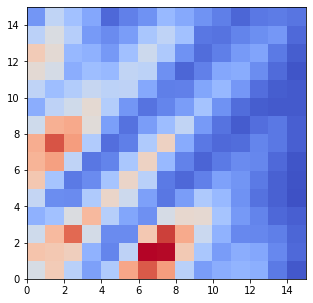

graph of model


<ipython-input-23-dcb881747886>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(range(0,16,1),range(0,16,1),color_graph_m, cmap='coolwarm',vmin=0,vmax=V_max)


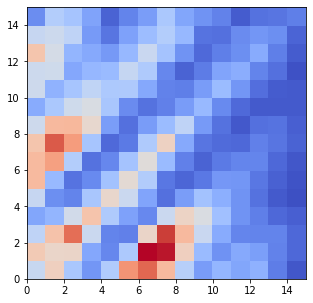

differences


<ipython-input-23-dcb881747886>:49: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(range(0,16,1),range(0,16,1),color_graph_dif, cmap='coolwarm')


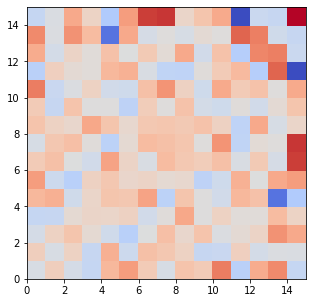

In [23]:
#heat map

plt.rcParams["figure.figsize"] = (5,5)

color_graph=[]

V_max=0 

for i in rules[setting].keys():
    color_graph.append([])
    for j in rules[setting][i]:
        color_graph[-1].append(rules[setting][i][j])
        if V_max<rules[setting][i][j]:
            V_max=rules[setting][i][j]
    
print('graph of data')       
plt.pcolor(range(0,16,1),range(0,16,1),color_graph, cmap='coolwarm',vmin=0,vmax=V_max)
plt.show()

color_graph_m=[]

for i in Metr_W["rules_m"][setting].keys():
    color_graph_m.append([])
    for j in Metr_W["rules_m"][setting][i]:
        color_graph_m[-1].append(Metr_W["rules_m"][setting][i][j])
        if V_max<Metr_W["rules_m"][setting][i][j]:
            V_max=Metr_W["rules_m"][setting][i][j]
    

print('graph of model')          
plt.pcolor(range(0,16,1),range(0,16,1),color_graph_m, cmap='coolwarm',vmin=0,vmax=V_max)
plt.show()

color_graph_dif=[]


for i in Metr_W["rules_m"][setting].keys():
    color_graph_dif.append([])
    for j in Metr_W["rules_m"][setting][i]:
        if rules[setting][i][j] != 0 :
            diff=Metr_W["rules_m"][setting][i][j]/rules[setting][i][j]
            color_graph_dif[-1].append(diff)
        elif rules[setting][i][j] == 0 :
            diff=0
            color_graph_dif[-1].append(diff)
        
            
print('differences')          
plt.pcolor(range(0,16,1),range(0,16,1),color_graph_dif, cmap='coolwarm')
plt.show()

### 5-3 metrics used for comparison of model and data

In [24]:
#this part returns p_value wilcoxon for comparison age stratified number of contacts 

print('p-value wilcoxon :','%f' % Metr_W['wilx'][1])

print('Pearson Corealtion :',Metr_W['prs_cor'][0],'%f' % Metr_W['prs_cor'][1])

print('mean absoloute error : ', Metr_W['M_Abs'])

print('Manhattan distance :',Metr_W['man_dis'])

print('Euclidean distance :',Metr_W['eu_dis'])

print('Chebyshev distance :',Metr_W['cheb_dis'])

p-value wilcoxon : 0.149549
Pearson Corealtion : 0.995125599534577 0.000000
mean absoloute error :  0.014448632615644748
Manhattan distance : 3.698849949605056
Euclidean distance : 0.31334146663225826
Chebyshev distance : 0.0706629917550099


### 5-4 time of running the model

In [25]:
print(end-start)

31.002280712127686


### 5-5 evaluation for clustring 

In [26]:
Clus=clustering_rate (results)
print('Num_triangel',Clus[0],'ratio_triangel',Clus[1])


Num_triangel 3969.0 ratio_triangel 0.20537100279416332


### 5-6 number of contacts in model and expected form data 

In [27]:

table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['source',' number of contacts']])
print(table.draw())

list_contacts={'data':0,'model':0}
#based on rules_sum
for i in rules_sum[setting].keys():

    list_contacts['data']+=rules_sum[setting][i]['contact_total']*age_count[i]
    
#based on contacts
for i in results['graph_array']:
    list_contacts['model']+=len(i[0])


for i in list_contacts.keys():
    
    table.add_rows([[i,'%f' %list_contacts[i]]])
    print(table.draw())
    
table.add_rows([['difference','%f' %(list_contacts['model']-list_contacts['data'])]])
print(table.draw())

        

source    number of contacts
 data       40573.199520    
model       40370.000000    
differ       -203.199520    
 ence                       


### 5-7 mean number of connections for each age in model and data

 age    house hold size data   house hold size model   population
 0_4          5.416068               5.445230            0.0849  
 5_9          5.983658               5.881919            0.0813  
10_14         5.736687               5.684798            0.0717  
15_19         4.466529               4.357353            0.068   
20_24         3.263884               3.267409            0.0718  
25_29         3.075611               3.063895            0.0986  
30_34         3.621801               3.618231            0.1108  
35_39         4.265990               4.297447            0.0901  
40_44         3.831050               3.907433            0.0713  
45_49         3.049710               2.918367            0.0686  
50_54         3.353310               3.322457            0.0521  
55_59         3.429105               3.349057            0.0424  
60_64         3.579534               3.582857            0.035   
65_69         3.313562               3.331915            0.0235  
70_74     

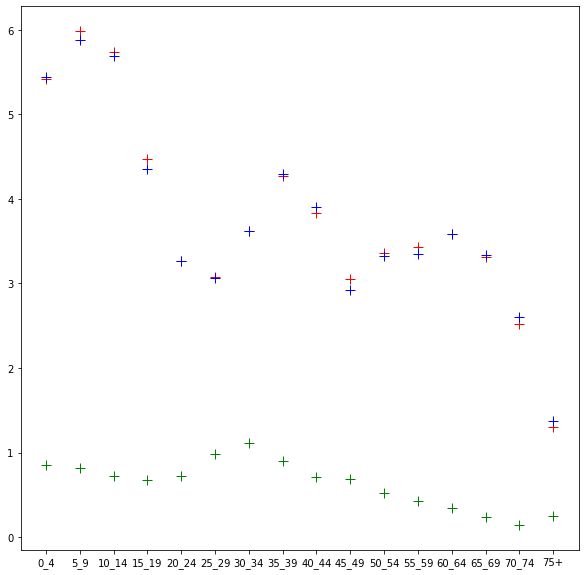

In [28]:
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([[' age ','house hold size data','house hold size model','population']])
print(table.draw())
plt.rcParams["figure.figsize"] = (10,10)

house_hold_size={}
for i in age_count.keys():
    house_hold_size[i]=0
for i in results['graph_array']:
    Age=nodes_dic[i[1]]['age']
    house_hold_size[Age]+=(len(i[0])/age_count[Age])

for i in rules_sum[setting].keys():
    table.add_rows([[i,'%f' %rules_sum[setting][i]['contact_total'],'%f' %house_hold_size[i],age_count[i]/N]])
    print(table.draw())
    plt.plot(i,rules_sum[setting][i]['contact_total'],'r+',linewidth=2, markersize=10,alpha=1)
    plt.plot(i,house_hold_size[i],'b+',linewidth=2, markersize=10,alpha=1)
    plt.plot(i,age_count[i]/(N/10),'g+',linewidth=2, markersize=10,alpha=1)

### 5-8 progress of metrics while model runs

p-value wilcoxon


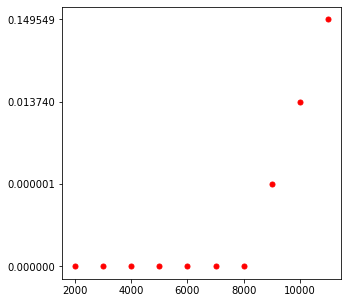

mean absoloute error


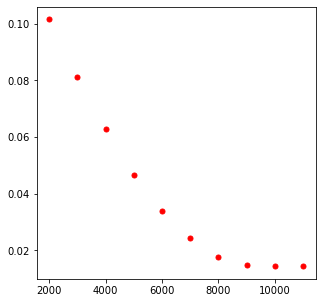

Manhattan distance


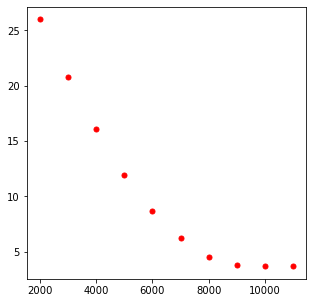

Euclidean distance


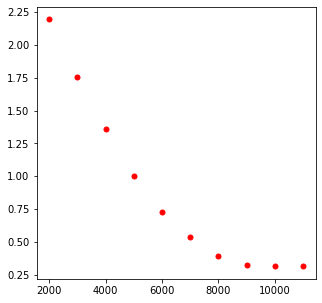

Chebyshev distance


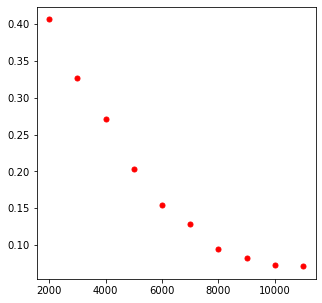

In [29]:
plt.rcParams["figure.figsize"] = (5,5)
samples=results['samples_T']
for metric in samples.keys():
    plt.show()
    print(metric)
    n_sample=sampling_ratio
    for i in samples[metric]:
        n_sample+=sampling_ratio
        plt.plot(n_sample,i,'r.',linewidth=2, markersize=10,alpha=1)
        